# 6 Cavity/Diagonal Design

### Preparations

In [1]:
# For convenience, let's begin by enabling
# automatic reloading of modules when they change.
%load_ext autoreload
%autoreload 2

import numpy as np
from collections import OrderedDict

import warnings
warnings.filterwarnings('ignore')

import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict
import matplotlib.pyplot as plt

from qiskit_metal.toolbox_metal import math_and_overrides

from qiskit_metal.qlibrary.core import QComponent

from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
from qiskit_metal.qlibrary.tlines.anchored_path import RouteAnchors

from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond

from qiskit_metal.qlibrary.terminations.open_to_ground_v2 import OpenToGround
from qiskit_metal.renderers.renderer_ansys.ansys_renderer import QAnsysRenderer

from qiskit_metal.analyses.sweep_and_optimize.sweeping import Sweeping

from qiskit_metal.qlibrary.terminations.ebeam_marker_v2 import Markers
from qiskit_metal.qlibrary.terminations.ebeam_frame import Frame

import pyEPR as epr
from qiskit_metal.analyses.quantization import EPRanalysis

In [2]:
# Each time you create a new quantum circuit design,
# you start by instantiating a QDesign class.

# The design class `DesignPlanar` is best for 2D circuit designs.
design = designs.DesignPlanar()
design.chips.main.material = 'silicon'  # our substrate is Silicon
# cpw_width and cpw_gap is defined from the beginnning if you need you can 
# change it later. But with this way one can be sure all the lines are having same width and gap.
design.variables['cpw_width'] = '15 um'  
design.variables['cpw_gap'] = '8.733 um'  
design._chips['main']['size']['size_x'] = '9mm'  # Our device size is 9*9mm
design._chips['main']['size']['size_y'] = '9mm'

# If you disable the next line with "overwrite_enabled", then you will need to
# delete a component [<component>.delete()] before recreating it.
design.overwrite_enabled = True


eig_qres = EPRanalysis(design, "hfss")
hfss = design.renderers.hfss
hfss = eig_qres.sim.renderer
q3d = design.renderers.q3d

# run the GUI 
gui = MetalGUI(design)

In [3]:
#Explore the options of the LaunchpadWirebondCoupled

LaunchpadWirebond.get_template_options(design)

{'pos_x': '0.0um',
 'pos_y': '0.0um',
 'orientation': '0.0',
 'chip': 'main',
 'layer': '1',
 'trace_width': 'cpw_width',
 'trace_gap': 'cpw_gap',
 'lead_length': '25um',
 'pad_width': '80um',
 'pad_height': '80um',
 'pad_gap': '58um',
 'taper_height': '122um'}

In [4]:
from qiskit_metal.qlibrary.terminations.ebeam_marker_v2 import Markers
from qiskit_metal.qlibrary.terminations.ebeam_frame import Frame

## Markers for ebeam
options = dict(pos_x='3.25mm', pos_y='4.25mm')
mrk1 = Markers(design, 'marker1', options = options)

options = dict(pos_x='-3.25mm', pos_y='4.25mm')
mrk2 = Markers(design, 'marker2', options = options)

options = dict(pos_x='-3.25mm', pos_y='-4.25mm')
mrk3 = Markers(design, 'marker3', options = options)

options = dict(pos_x='3.25mm', pos_y='-4.25mm')
mrk4 = Markers(design, 'marker4', options = options)

options = dict(chip='main')
frame = Frame(design, 'frame', options = options)

gui.rebuild()

In [5]:
#Setup the launchpad1 location and orientation

## Read In launch pad
launch_options = dict(chip='main', pos_x='-4.0mm', pos_y='-4.0mm', orientation='0',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='112um',
                    )
lp = LaunchpadWirebond(design, 'LPReadIn', options = launch_options)


# Read Out launch pad
launch_options = dict(chip='main', pos_x='4.0mm', pos_y='4.0mm', orientation='180',
                      lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='112um',
                    )
lp = LaunchpadWirebond(design, 'LPReadOut', options = launch_options)


from collections import OrderedDict
jogs_in = OrderedDict()
jogs_in[0] = ["L", '3990um']
jogs_in[1] = ["L", '4800um']
jogs_in[2] = ["R", '3900um']

Transmission_Line = {'pin_inputs':
           {'start_pin': {'component': 'LPReadIn', 'pin': 'tie'},
             'end_pin': {'component': 'LPReadOut', 'pin': 'tie'}},
            'lead': {'start_straight': '8000um', 'end_straight': '8000um',
                    # 'start_jogged_extension': jogs_in,
                    # 'anchors': anchors1,
                    }, 
                    'total_length': '8mm', 'fillet': "90um"
            }

TransLine = RoutePathfinder(design, 'TL', Transmission_Line)


gui.rebuild()

In [6]:
# Look at the options of the launch pad in QDesign.
lp.options

{'pos_x': '4.0mm',
 'pos_y': '4.0mm',
 'orientation': '180',
 'chip': 'main',
 'layer': '1',
 'trace_width': 'cpw_width',
 'trace_gap': 'cpw_gap',
 'lead_length': '30um',
 'pad_width': '200um',
 'pad_height': '200um',
 'pad_gap': '112um',
 'taper_height': '122um'}

In [104]:
# Lambda/2 resonators - Resonator1
otg1s = OpenToGround(design, 'otg1s', options=dict(pos_x='-2.0mm', pos_y='-3.963mm', orientation='0'))
otg1e = OpenToGround(design, 'otg1e', options=dict(pos_x='-2.5mm', pos_y='-2.2mm', orientation='180'))
rt_meander = RouteMeander(design, 'cavity1',  Dict(meander=Dict(spacing='200um'),
        total_length='14.8mm',
        hfss_wire_bonds = True,
        fillet='99um',
        lead = dict(start_straight='250um'),
        pin_inputs=Dict(
            start_pin=Dict(component='otg1s', pin='open'),
            end_pin=Dict(component='otg1e', pin='open')), ))


# Lambda/2 resonators - Resonator2
otg2s = OpenToGround(design, 'otg2s', options=dict(pos_x='0.8mm', pos_y='-3.963mm', orientation='0'))
otg2e = OpenToGround(design, 'otg2e', options=dict(pos_x='-0.0mm', pos_y='-2.2mm', orientation='180'))
rt_meander = RouteMeander(design, 'cavity2',  Dict(meander=Dict(spacing='200um'),
        total_length='13.84mm',
        hfss_wire_bonds = True,
        fillet='99um',
        lead = dict(start_straight='250um'),
        pin_inputs=Dict(
            start_pin=Dict(component='otg2s', pin='open'),
            end_pin=Dict(component='otg2e', pin='open')), ))


# Lambda/2 resonators - Resonator3
otg3s = OpenToGround(design, 'otg3s', options=dict(pos_x='3.0mm',  pos_y='-3.963mm', orientation='0'))
otg3e = OpenToGround(design, 'otg3e', options=dict(pos_x='3.0mm', pos_y='-2.2mm', orientation='180'))
rt_meander = RouteMeander(design, 'cavity3',  Dict(meander=Dict(spacing='200um'),
        total_length='12.80mm',
        hfss_wire_bonds = True,
        fillet='99um',
        lead = dict(start_straight='250um'),
        pin_inputs=Dict(
            start_pin=Dict(component='otg3s', pin='open'),
            end_pin=Dict(component='otg3e', pin='open')), ))

gui.rebuild()

In [105]:
# Lambda/2 resonators - Resonator4
otg4s = OpenToGround(design, 'otg4s', options=dict(pos_x='-3.0mm', pos_y='-0.037733mm', orientation='0'))
otg4e = OpenToGround(design, 'otg4e', options=dict(pos_x='-3.5mm', pos_y='-1.8mm', orientation='180'))
rt_meander = RouteMeander(design, 'cavity4',  Dict(meander=Dict(spacing='200um'),
        total_length='12.0mm',
        hfss_wire_bonds = True,
        fillet='99um',
        lead = dict(start_straight='250um'),
        pin_inputs=Dict(
            start_pin=Dict(component='otg4s', pin='open'),
            end_pin=Dict(component='otg4e', pin='open')), ))


# Lambda/2 resonators - Resonator5
otg5s = OpenToGround(design, 'otg5s', options=dict(pos_x='-0.5mm', pos_y='-0.037733mm', orientation='0'))
otg5e = OpenToGround(design, 'otg5e', options=dict(pos_x='-1.0mm', pos_y='-1.8mm', orientation='180'))
rt_meander = RouteMeander(design, 'cavity5',  Dict(meander=Dict(spacing='200um'),
        total_length='11.4mm',
        hfss_wire_bonds = True,
        fillet='99um',
        lead = dict(start_straight='250um'),
        pin_inputs=Dict(
            start_pin=Dict(component='otg5s', pin='open'),
            end_pin=Dict(component='otg5e', pin='open')), ))


# Lambda/2 resonators - Resonator6
otg6s = OpenToGround(design, 'otg6s', options=dict(pos_x='2.2mm',  pos_y='-0.037733mm', orientation='0'))
otg6e = OpenToGround(design, 'otg6e', options=dict(pos_x='1.8mm', pos_y='-1.8mm', orientation='180'))
rt_meander = RouteMeander(design, 'cavity6',  Dict(meander=Dict(spacing='200um'),
        total_length='10.792mm',
        hfss_wire_bonds = True,
        fillet='99um',
        lead = dict(start_straight='250um'),
        pin_inputs=Dict(
            start_pin=Dict(component='otg6s', pin='open'),
            end_pin=Dict(component='otg6e', pin='open')), ))



gui.rebuild()

In [106]:
# Lambda/2 resonators - Resonator7
otg7s = OpenToGround(design, 'otg7s', options=dict(pos_x='-1.8mm', pos_y='0.037733mm', orientation='0'))
otg7e = OpenToGround(design, 'otg7e', options=dict(pos_x='-2.5mm', pos_y='1.4mm', orientation='180'))
rt_meander = RouteMeander(design, 'cavity7',  Dict(meander=Dict(spacing='200um'),
        total_length='10.20mm',
        hfss_wire_bonds = True,
        fillet='99um',
        lead = dict(start_straight='250um'),
        pin_inputs=Dict(
            start_pin=Dict(component='otg7s', pin='open'),
            end_pin=Dict(component='otg7e', pin='open')), ))


# Lambda/2 resonators - Resonator8
otg8s = OpenToGround(design, 'otg8s', options=dict(pos_x='1.0mm', pos_y='0.037733mm', orientation='0'))
otg8e = OpenToGround(design, 'otg8e', options=dict(pos_x='1.0mm', pos_y='1.4mm', orientation='180'))
rt_meander = RouteMeander(design, 'cavity8',  Dict(meander=Dict(spacing='200um'),
        total_length='9.7mm',
        hfss_wire_bonds = True,
        fillet='99um',
        lead = dict(start_straight='250um'),
        pin_inputs=Dict(
            start_pin=Dict(component='otg8s', pin='open'),
            end_pin=Dict(component='otg8e', pin='open')), ))


# Lambda/2 resonators - Resonator9
otg9s = OpenToGround(design, 'otg9s', options=dict(pos_x='3.5mm',  pos_y='0.037733mm', orientation='0'))
otg9e = OpenToGround(design, 'otg9e', options=dict(pos_x='2.8mm', pos_y='1.4mm', orientation='180'))
rt_meander = RouteMeander(design, 'cavity9',  Dict(meander=Dict(spacing='200um'),
        total_length='9.15mm',
        hfss_wire_bonds = True,
        fillet='99um',
        lead = dict(start_straight='250um'),
        pin_inputs=Dict(
            start_pin=Dict(component='otg9s', pin='open'),
            end_pin=Dict(component='otg9e', pin='open')), ))



gui.rebuild()

In [107]:
# Lambda/2 resonators - Resonator10
otg10s = OpenToGround(design, 'otg10s', options=dict(pos_x='-2.8mm', pos_y='3.963mm', orientation='0'))
otg10e = OpenToGround(design, 'otg10e', options=dict(pos_x='-3.5mm', pos_y='2.2mm', orientation='180'))
rt_meander = RouteMeander(design, 'cavity10',  Dict(meander=Dict(spacing='200um'),
        total_length='8.80mm',
        hfss_wire_bonds = True,
        fillet='99um',
        lead = dict(start_straight='250um'),
        pin_inputs=Dict(
            start_pin=Dict(component='otg10s', pin='open'),
            end_pin=Dict(component='otg10e', pin='open')), ))


# Lambda/2 resonators - Resonator11
otg11s = OpenToGround(design, 'otg11s', options=dict(pos_x='-0.2mm', pos_y='3.963mm', orientation='0'))
otg11e = OpenToGround(design, 'otg11e', options=dict(pos_x='-0.8mm', pos_y='2.2mm', orientation='180'))
rt_meander = RouteMeander(design, 'cavity11',  Dict(meander=Dict(spacing='200um'),
        total_length='8.46mm',
        hfss_wire_bonds = True,
        fillet='99um',
        lead = dict(start_straight='250um'),
        pin_inputs=Dict(
            start_pin=Dict(component='otg11s', pin='open'),
            end_pin=Dict(component='otg11e', pin='open')), ))


# Lambda/2 resonators - Resonator12
otg12s = OpenToGround(design, 'otg12s', options=dict(pos_x='2.5mm',  pos_y='3.963mm', orientation='0'))
otg12e = OpenToGround(design, 'otg12e', options=dict(pos_x='2.3mm', pos_y='2.2mm', orientation='180'))
rt_meander = RouteMeander(design, 'cavity12',  Dict(meander=Dict(spacing='200um'),
        total_length='8.12mm',
        hfss_wire_bonds = True,
        fillet='99um',
        lead = dict(start_straight='250um'),
        pin_inputs=Dict(
            start_pin=Dict(component='otg12s', pin='open'),
            end_pin=Dict(component='otg12e', pin='open')), ))


gui.rebuild()

In [11]:
design.net_info

,net_id,component_id,pin_name
0,71,6,tie
1,71,8,start
2,72,7,tie
3,72,8,end
4,73,9,open
5,73,11,start
6,74,10,open
7,74,11,end
8,75,12,open
9,75,14,start


In [12]:
design.chips.main

{'material': 'silicon',
 'layer_start': '0',
 'layer_end': '2048',
 'size': {'center_x': '0.0mm',
  'center_y': '0.0mm',
  'center_z': '0.0mm',
  'size_x': '9mm',
  'size_y': '9mm',
  'size_z': '-750um',
  'sample_holder_top': '890um',
  'sample_holder_bottom': '1650um'}}

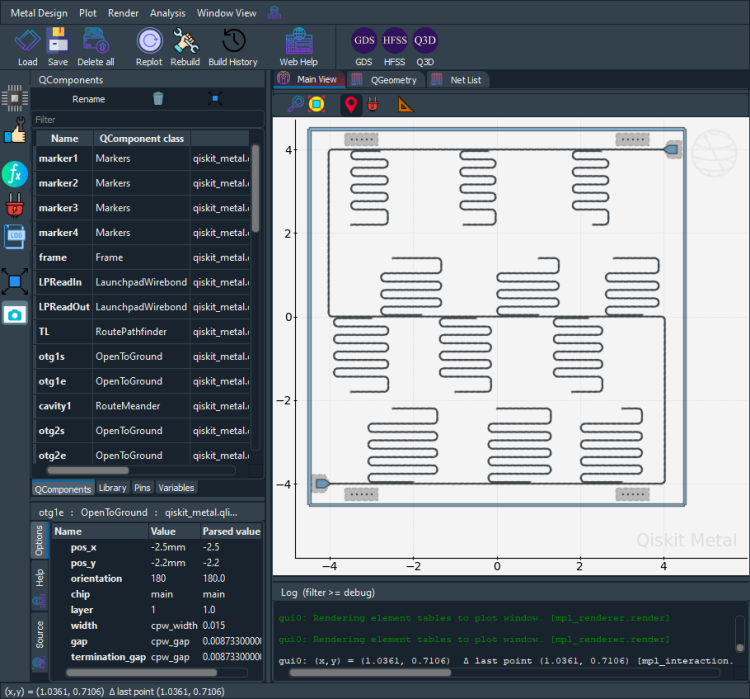

In [108]:
#Save screenshot as a .png formatted file.
gui.screenshot()

## Ansys QRenderer
How to Render a Metal Design into Ansys

In [26]:
from qiskit_metal.renderers.renderer_ansys.ansys_renderer import QAnsysRenderer
QAnsysRenderer.default_options

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'x_buffer_width_mm': 0.2,
 'y_buffer_width_mm': 0.2,
 'wb_threshold': '400um',
 'wb_offset': '0um',
 'wb_size': 5,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

!!!Make sure the programm is ready completly.

First, you open the ANSYS with the next cell. And then need to connect to it. After that you will see all cavities one by one rendered. You can try that as well. If you want you can clear the design right after every cavity and continue or no need to clear. At the end you will see all chip.

In [27]:
hfss.open_ansys()

In [28]:
hfss.connect_ansys()

INFO 02:40PM [connect_project]: Connecting to Ansys Desktop API...
INFO 02:40PM [load_ansys_project]: 	Opened Ansys App
INFO 02:40PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 02:40PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    //tudelft.net/staff-homes/Y/figenyilmaz/My Documents/Ansoft/
	Project:   Project17
INFO 02:40PM [connect_design]: No active design found (or error getting active design).
INFO 02:40PM [connect]: 	 Connected to project "Project17". No design detected


In [29]:
hfss.activate_eigenmode_design("cavity1")

02:40PM 41s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
02:40PM 41s WARNING [activate_ansys_design]: The design_name=cavity1 was not in active project.  Designs in active project are: 
[].  A new design will be added to the project.  
INFO 02:40PM [connect_design]: 	Opened active design
	Design:    cavity1 [Solution type: Eigenmode]
WARNING 02:40PM [connect_setup]: 	No design setup detected.
WARNING 02:40PM [connect_setup]: 	Creating eigenmode default setup.
INFO 02:40PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [30]:
hfss.render_design(['cavity1', 'otg1s', 'otg1e'])

In [31]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 15
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
#pinfo.design.set_variable('Lj', '10 nH')
#pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 02:45PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 1
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


02:47PM 50s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


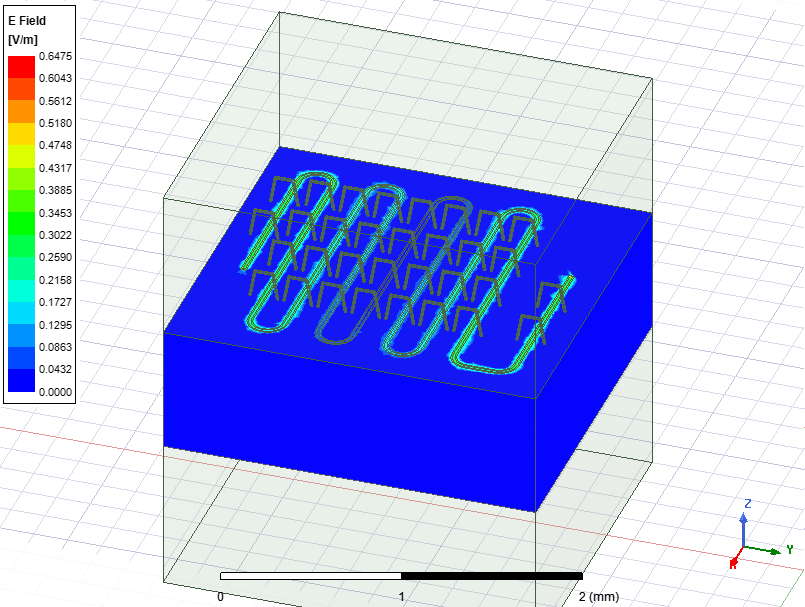

WindowsPath('C:/Users/figenyilmaz/GitLab/figen-qiskit-metal/Shitty-Files/SixCavityDiagonal/ansys.png')

In [32]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [33]:
eprd = epr.DistributedAnalysis(hfss.pinfo)

Design "cavity1" info:
	# eigenmodes    1
	# variations    1


In [34]:
eprd.get_ansys_frequencies_all()

,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,4.004643,inf


In [35]:
hfss.clean_active_design()

In [109]:
hfss.activate_eigenmode_design("cavity2-2")

03:47PM 24s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
03:47PM 24s WARNING [activate_ansys_design]: The design_name=cavity2-2 was not in active project.  Designs in active project are: 
['cavity2', 'cavity1', 'cavity7', 'cavity3', 'cavity6', 'cavity4', 'cavity5', 'cavity8', 'cavity12', 'cavity10', 'cavity9', 'cavity11'].  A new design will be added to the project.  
INFO 03:47PM [connect_design]: 	Opened active design
	Design:    cavity2-2 [Solution type: Eigenmode]
WARNING 03:47PM [connect_setup]: 	No design setup detected.
WARNING 03:47PM [connect_setup]: 	Creating eigenmode default setup.
INFO 03:47PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [110]:
hfss.render_design(['cavity2', 'otg2s', 'otg2e'])

In [111]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 15
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
#pinfo.design.set_variable('Lj', '10 nH')
#pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 03:48PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 1
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


### Plot fields and display them
Display the Ansys modeler window and plot the E-field on the chip's surface.

03:50PM 06s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


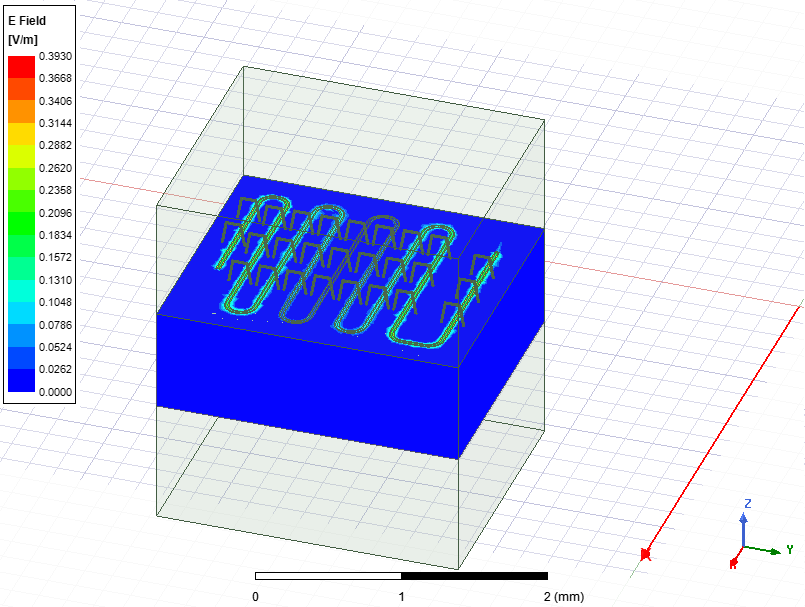

WindowsPath('C:/Users/figenyilmaz/GitLab/figen-qiskit-metal/Shitty-Files/SixCavityDiagonal/ansys.png')

In [112]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [113]:
eprd = epr.DistributedAnalysis(hfss.pinfo)

Design "cavity2-2" info:
	# eigenmodes    1
	# variations    1


In [114]:
eprd.get_ansys_frequencies_all()

,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,4.289881,inf


In [115]:
hfss.clean_active_design()

In [116]:
hfss.activate_eigenmode_design("cavity3-2")

03:50PM 10s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
03:50PM 10s WARNING [activate_ansys_design]: The design_name=cavity3-2 was not in active project.  Designs in active project are: 
['cavity2', 'cavity1', 'cavity7', 'cavity3', 'cavity6', 'cavity4', 'cavity5', 'cavity8', 'cavity12', 'cavity2-2', 'cavity10', 'cavity9', 'cavity11'].  A new design will be added to the project.  
INFO 03:50PM [connect_design]: 	Opened active design
	Design:    cavity3-2 [Solution type: Eigenmode]
WARNING 03:50PM [connect_setup]: 	No design setup detected.
WARNING 03:50PM [connect_setup]: 	Creating eigenmode default setup.
INFO 03:50PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [117]:
hfss.render_design(['cavity3', 'otg3s', 'otg3e'])

In [118]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 15
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
#pinfo.design.set_variable('Lj', '10 nH')
#pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 03:50PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 1
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


03:52PM 46s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


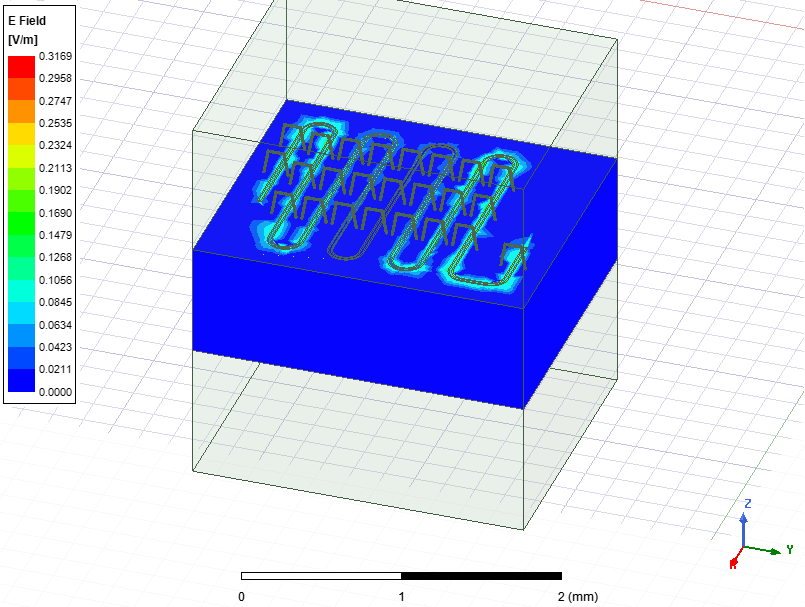

WindowsPath('C:/Users/figenyilmaz/GitLab/figen-qiskit-metal/Shitty-Files/SixCavityDiagonal/ansys.png')

In [119]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [120]:
eprd = epr.DistributedAnalysis(hfss.pinfo)

Design "cavity3-2" info:
	# eigenmodes    1
	# variations    1


In [121]:
eprd.get_ansys_frequencies_all()

,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,4.278147,inf


In [122]:
hfss.activate_eigenmode_design("cavity4-2")

03:53PM 01s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
03:53PM 01s WARNING [activate_ansys_design]: The design_name=cavity4-2 was not in active project.  Designs in active project are: 
['cavity2', 'cavity1', 'cavity7', 'cavity3', 'cavity6', 'cavity4', 'cavity5', 'cavity8', 'cavity12', 'cavity3-2', 'cavity2-2', 'cavity10', 'cavity9', 'cavity11'].  A new design will be added to the project.  
INFO 03:53PM [connect_design]: 	Opened active design
	Design:    cavity4-2 [Solution type: Eigenmode]
WARNING 03:53PM [connect_setup]: 	No design setup detected.
WARNING 03:53PM [connect_setup]: 	Creating eigenmode default setup.
INFO 03:53PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [123]:
hfss.render_design(['cavity4', 'otg4s', 'otg4e'])

In [124]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 15
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
#pinfo.design.set_variable('Lj', '10 nH')
#pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 03:53PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 1
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


03:55PM 49s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


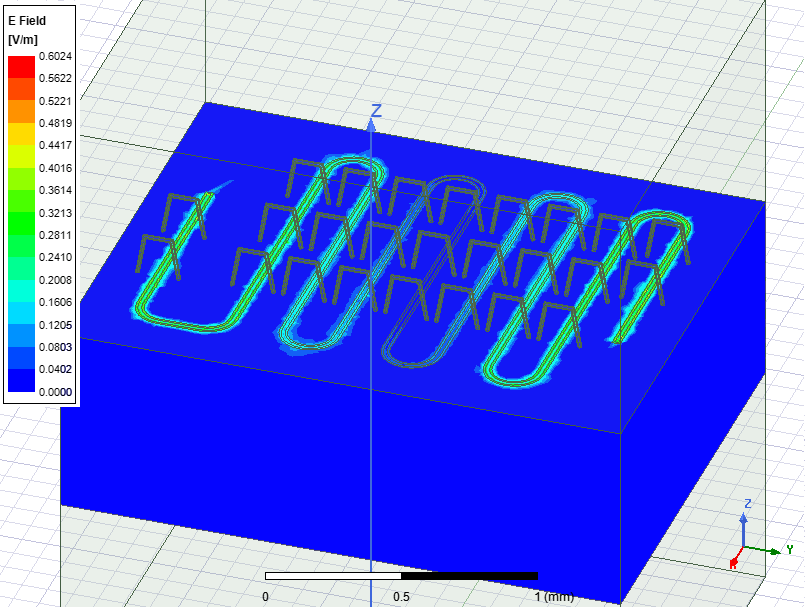

WindowsPath('C:/Users/figenyilmaz/GitLab/figen-qiskit-metal/Shitty-Files/SixCavityDiagonal/ansys.png')

In [125]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [126]:
eprd = epr.DistributedAnalysis(hfss.pinfo)

Design "cavity4-2" info:
	# eigenmodes    1
	# variations    1


In [127]:
eprd.get_ansys_frequencies_all()

,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,4.987888,inf


In [55]:
hfss.activate_eigenmode_design("cavity5")

03:02PM 27s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
03:02PM 27s WARNING [activate_ansys_design]: The design_name=cavity5 was not in active project.  Designs in active project are: 
['cavity2', 'cavity1', 'cavity3', 'cavity4'].  A new design will be added to the project.  
INFO 03:02PM [connect_design]: 	Opened active design
	Design:    cavity5 [Solution type: Eigenmode]
WARNING 03:02PM [connect_setup]: 	No design setup detected.
WARNING 03:02PM [connect_setup]: 	Creating eigenmode default setup.
INFO 03:02PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [56]:
hfss.render_design(['cavity5', 'otg5s', 'otg5e'])

In [57]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 15
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
#pinfo.design.set_variable('Lj', '10 nH')
#pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 03:02PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 1
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


03:05PM 59s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


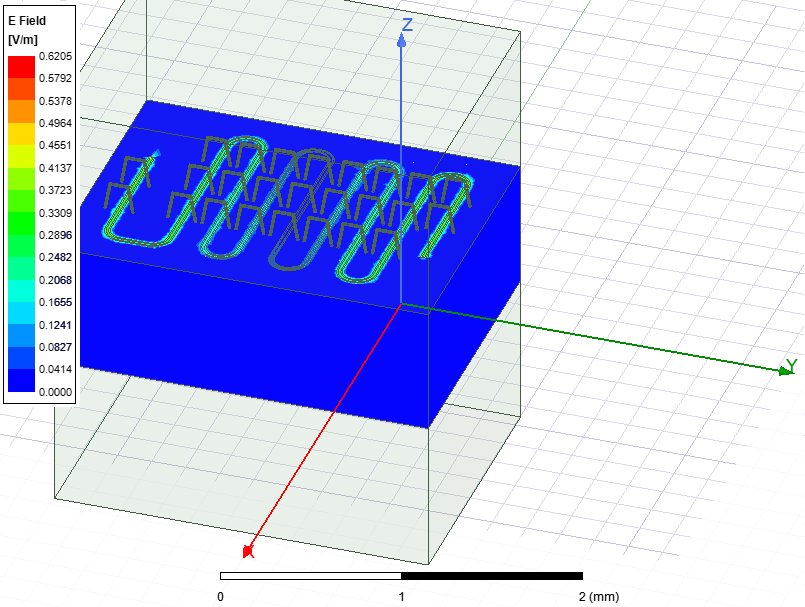

WindowsPath('C:/Users/figenyilmaz/GitLab/figen-qiskit-metal/Shitty-Files/SixCavityDiagonal/ansys.png')

In [58]:
hfss.modeler._modeler.ShowWindow()

hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [59]:
eprd = epr.DistributedAnalysis(hfss.pinfo)

Design "cavity5" info:
	# eigenmodes    1
	# variations    1


In [60]:
eprd.get_ansys_frequencies_all()

,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,5.19658,inf


In [128]:
hfss.activate_eigenmode_design("cavity6-2")

03:55PM 53s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
03:55PM 53s WARNING [activate_ansys_design]: The design_name=cavity6-2 was not in active project.  Designs in active project are: 
['cavity2', 'cavity1', 'cavity7', 'cavity3', 'cavity6', 'cavity4', 'cavity5', 'cavity8', 'cavity12', 'cavity3-2', 'cavity2-2', 'cavity10', 'cavity9', 'cavity11', 'cavity4-2'].  A new design will be added to the project.  
INFO 03:55PM [connect_design]: 	Opened active design
	Design:    cavity6-2 [Solution type: Eigenmode]
WARNING 03:55PM [connect_setup]: 	No design setup detected.
WARNING 03:55PM [connect_setup]: 	Creating eigenmode default setup.
INFO 03:55PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [129]:
hfss.render_design(['cavity6', 'otg6s', 'otg6e'])

In [130]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 15
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
#pinfo.design.set_variable('Lj', '20 nH')
#pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 03:56PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 1
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


03:58PM 56s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


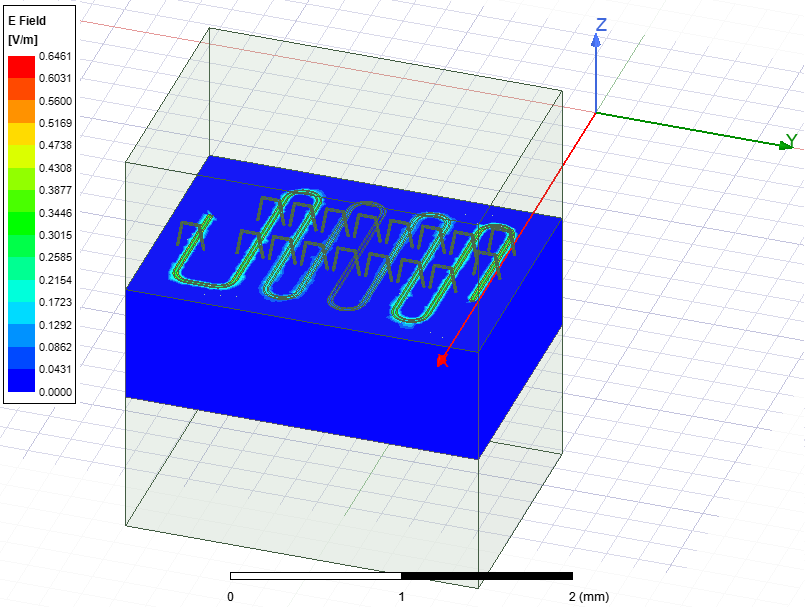

WindowsPath('C:/Users/figenyilmaz/GitLab/figen-qiskit-metal/Shitty-Files/SixCavityDiagonal/ansys.png')

In [131]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [132]:
eprd = epr.DistributedAnalysis(hfss.pinfo)

Design "cavity6-2" info:
	# eigenmodes    1
	# variations    1


In [133]:
eprd.get_ansys_frequencies_all()

,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,5.502015,inf


In [67]:
hfss.activate_eigenmode_design("cavity7")

03:08PM 37s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
03:08PM 37s WARNING [activate_ansys_design]: The design_name=cavity7 was not in active project.  Designs in active project are: 
['cavity2', 'cavity1', 'cavity3', 'cavity6', 'cavity4', 'cavity5'].  A new design will be added to the project.  
INFO 03:08PM [connect_design]: 	Opened active design
	Design:    cavity7 [Solution type: Eigenmode]
WARNING 03:08PM [connect_setup]: 	No design setup detected.
WARNING 03:08PM [connect_setup]: 	Creating eigenmode default setup.
INFO 03:08PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [68]:
hfss.render_design(['cavity7', 'otg7s', 'otg7e'])

In [70]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 15
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
#pinfo.design.set_variable('Lj', '20 nH')
#pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 03:14PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 1
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


03:14PM 14s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


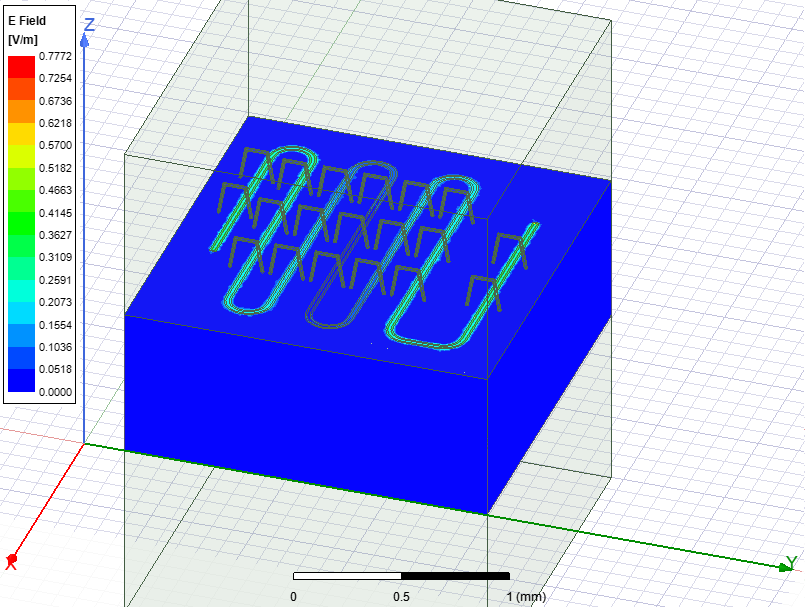

WindowsPath('C:/Users/figenyilmaz/GitLab/figen-qiskit-metal/Shitty-Files/SixCavityDiagonal/ansys.png')

In [71]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [72]:
eprd = epr.DistributedAnalysis(hfss.pinfo)

Design "cavity7" info:
	# eigenmodes    1
	# variations    1


In [73]:
eprd.get_ansys_frequencies_all()

,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,5.802506,inf


In [74]:
hfss.activate_eigenmode_design("cavity8")

03:14PM 18s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
03:14PM 18s WARNING [activate_ansys_design]: The design_name=cavity8 was not in active project.  Designs in active project are: 
['cavity2', 'cavity1', 'cavity7', 'cavity3', 'cavity6', 'cavity4', 'cavity5'].  A new design will be added to the project.  
INFO 03:14PM [connect_design]: 	Opened active design
	Design:    cavity8 [Solution type: Eigenmode]
WARNING 03:14PM [connect_setup]: 	No design setup detected.
WARNING 03:14PM [connect_setup]: 	Creating eigenmode default setup.
INFO 03:14PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [75]:
hfss.render_design(['cavity8', 'otg8s', 'otg8e'])

In [76]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 15
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
#pinfo.design.set_variable('Lj', '20 nH')
#pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 03:14PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 1
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


03:16PM 17s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


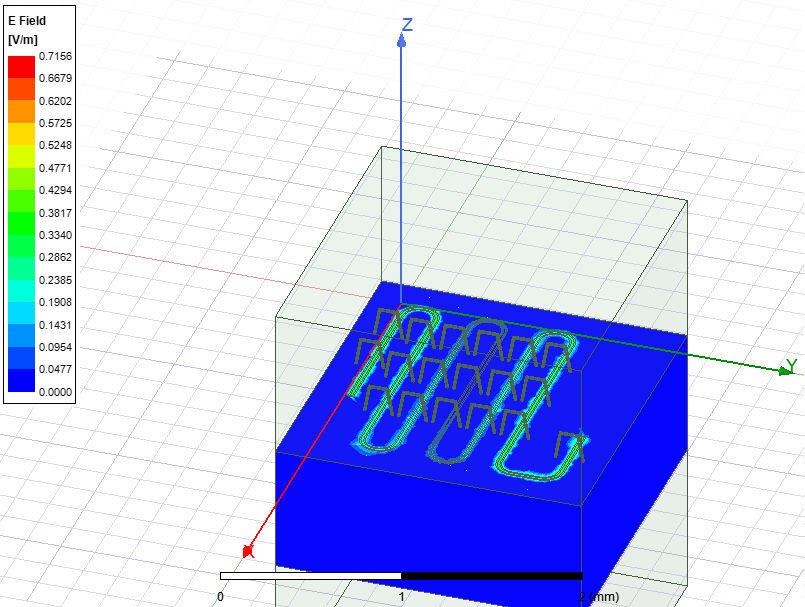

WindowsPath('C:/Users/figenyilmaz/GitLab/figen-qiskit-metal/Shitty-Files/SixCavityDiagonal/ansys.png')

In [77]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [78]:
eprd = epr.DistributedAnalysis(hfss.pinfo)

Design "cavity8" info:
	# eigenmodes    1
	# variations    1


In [79]:
eprd.get_ansys_frequencies_all()

,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,6.106043,inf


In [134]:
hfss.activate_eigenmode_design("cavity9-2")

03:59PM 00s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
03:59PM 00s WARNING [activate_ansys_design]: The design_name=cavity9-2 was not in active project.  Designs in active project are: 
['cavity2', 'cavity1', 'cavity7', 'cavity3', 'cavity6', 'cavity4', 'cavity5', 'cavity8', 'cavity12', 'cavity3-2', 'cavity2-2', 'cavity10', 'cavity9', 'cavity11', 'cavity4-2', 'cavity6-2'].  A new design will be added to the project.  
INFO 03:59PM [connect_design]: 	Opened active design
	Design:    cavity9-2 [Solution type: Eigenmode]
WARNING 03:59PM [connect_setup]: 	No design setup detected.
WARNING 03:59PM [connect_setup]: 	Creating eigenmode default setup.
INFO 03:59PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [135]:
hfss.render_design(['cavity9', 'otg9s', 'otg9e'])

In [136]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 15
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
#pinfo.design.set_variable('Lj', '20 nH')
#pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 03:59PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 1
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


04:02PM 52s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


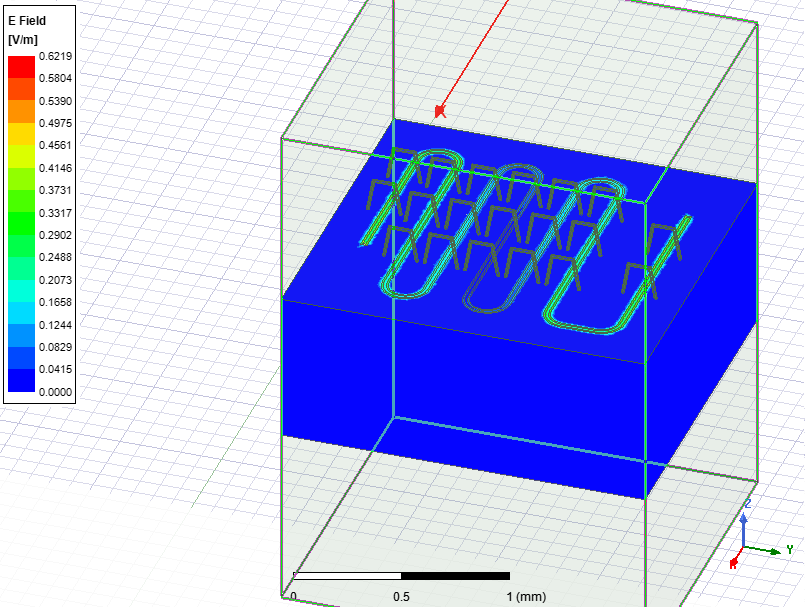

WindowsPath('C:/Users/figenyilmaz/GitLab/figen-qiskit-metal/Shitty-Files/SixCavityDiagonal/ansys.png')

In [137]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [138]:
eprd = epr.DistributedAnalysis(hfss.pinfo)

Design "cavity9-2" info:
	# eigenmodes    1
	# variations    1


In [139]:
eprd.get_ansys_frequencies_all()

,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,6.464111,inf


In [140]:
hfss.activate_eigenmode_design("cavity10-2")

04:02PM 57s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
04:02PM 57s WARNING [activate_ansys_design]: The design_name=cavity10-2 was not in active project.  Designs in active project are: 
['cavity2', 'cavity1', 'cavity7', 'cavity3', 'cavity6', 'cavity4', 'cavity5', 'cavity8', 'cavity12', 'cavity3-2', 'cavity2-2', 'cavity10', 'cavity9', 'cavity11', 'cavity9-2', 'cavity4-2', 'cavity6-2'].  A new design will be added to the project.  
INFO 04:02PM [connect_design]: 	Opened active design
	Design:    cavity10-2 [Solution type: Eigenmode]
WARNING 04:02PM [connect_setup]: 	No design setup detected.
WARNING 04:02PM [connect_setup]: 	Creating eigenmode default setup.
INFO 04:02PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [141]:
hfss.render_design(['cavity10', 'otg10s', 'otg10e'])

In [142]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 15
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
#pinfo.design.set_variable('Lj', '20 nH')
#pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 04:06PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 1
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


04:08PM 54s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


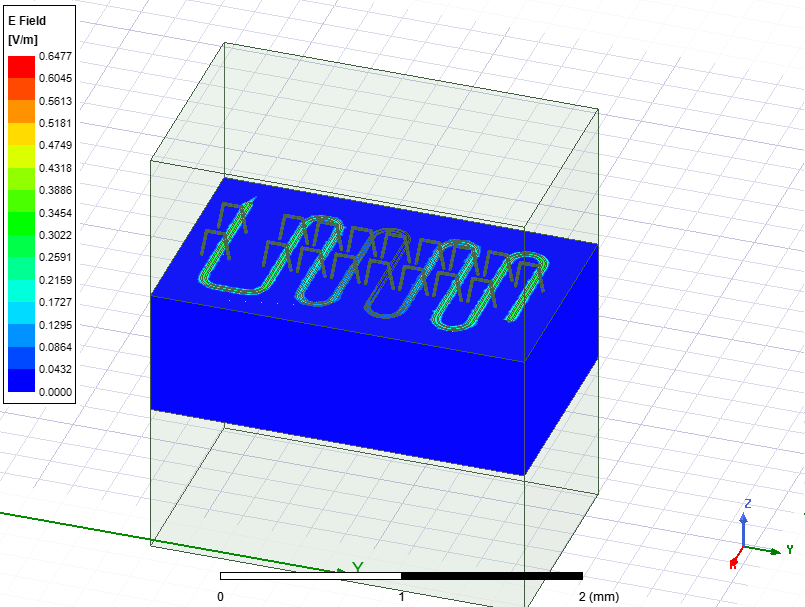

WindowsPath('C:/Users/figenyilmaz/GitLab/figen-qiskit-metal/Shitty-Files/SixCavityDiagonal/ansys.png')

In [143]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [144]:
eprd = epr.DistributedAnalysis(hfss.pinfo)

Design "cavity10-2" info:
	# eigenmodes    1
	# variations    1


In [145]:
eprd.get_ansys_frequencies_all()

,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,6.726108,inf


In [146]:
hfss.activate_eigenmode_design("cavity11")

04:14PM 04s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
INFO 04:14PM [connect_design]: 	Opened active design
	Design:    cavity11 [Solution type: Eigenmode]


In [93]:
hfss.render_design(['cavity11', 'otg11s', 'otg11e'])

In [94]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 15
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
#pinfo.design.set_variable('Lj', '20 nH')
#pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 03:30PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 1
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


03:31PM 18s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


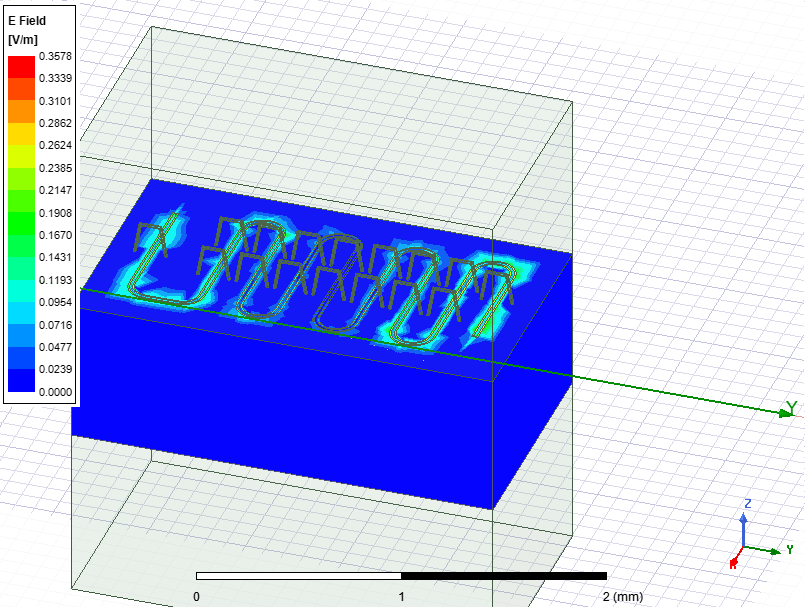

WindowsPath('C:/Users/figenyilmaz/GitLab/figen-qiskit-metal/Shitty-Files/SixCavityDiagonal/ansys.png')

In [95]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [96]:
eprd = epr.DistributedAnalysis(hfss.pinfo)

Design "cavity11" info:
	# eigenmodes    1
	# variations    1


In [97]:
eprd.get_ansys_frequencies_all()

,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,6.977219,inf


In [98]:
hfss.activate_eigenmode_design("cavity12")

03:31PM 26s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
03:31PM 26s WARNING [activate_ansys_design]: The design_name=cavity12 was not in active project.  Designs in active project are: 
['cavity2', 'cavity1', 'cavity7', 'cavity3', 'cavity6', 'cavity4', 'cavity5', 'cavity8', 'cavity10', 'cavity9', 'cavity11'].  A new design will be added to the project.  
INFO 03:31PM [connect_design]: 	Opened active design
	Design:    cavity12 [Solution type: Eigenmode]
WARNING 03:31PM [connect_setup]: 	No design setup detected.
WARNING 03:31PM [connect_setup]: 	Creating eigenmode default setup.
INFO 03:31PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [99]:
hfss.render_design(['cavity12', 'otg12s', 'otg12e'])

In [100]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 15
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
#pinfo.design.set_variable('Lj', '20 nH')
#pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 03:31PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 1
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


03:34PM 13s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


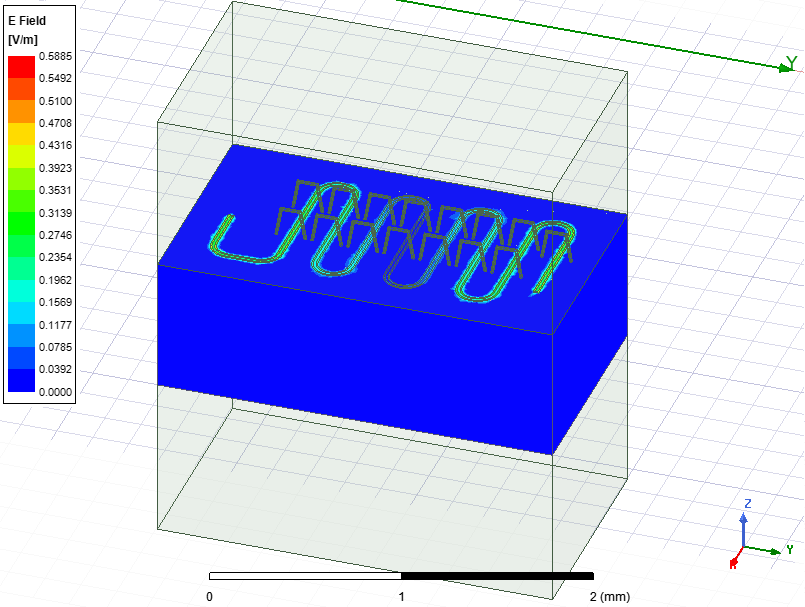

WindowsPath('C:/Users/figenyilmaz/GitLab/figen-qiskit-metal/Shitty-Files/SixCavityDiagonal/ansys.png')

In [101]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [102]:
eprd = epr.DistributedAnalysis(hfss.pinfo)

Design "cavity12" info:
	# eigenmodes    1
	# variations    1


In [103]:
eprd.get_ansys_frequencies_all()

,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,7.306711,inf


In [147]:
hfss.disconnect_ansys()

In [148]:
gui.main_window.close()

True